# Tensorboard

## Add image

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.transforms import *
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
from collections import defaultdict
import time
import copy

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_dataloaders():
    def clean_up(path):
        import os
        from shutil import rmtree
        
        ipynb_checkpoints = f'{path}/.ipynb_checkpoints'
        if os.path.exists(ipynb_checkpoints):
            rmtree(ipynb_checkpoints)
            
    def get_dataloader(phase):
        path = f'./shapes/{phase}'
        clean_up(path)
        
        if phase in ['valid']:
            transform = transforms.Compose([
                Resize(224), 
                ToTensor()])
        else:
            transform = transforms.Compose([
                Resize(224), 
                RandomAffine(degrees=(30, 50), shear=5),
                ToTensor()])
            
        image_folder = datasets.ImageFolder(path, transform=transform)
        # print(path, image_folder.classes)
        return DataLoader(image_folder, batch_size=4, shuffle=True, num_workers=4)
    
    return {phase: get_dataloader(phase) for phase in ['train', 'test', 'valid']}

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
pretrained=True
num_classes = 3
writer = SummaryWriter('/root/tensorboard/shape_experiment_1')

dataloaders = get_dataloaders()

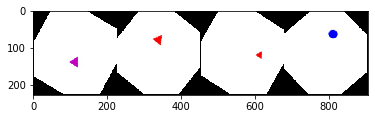

In [2]:
data_iter = iter(dataloaders['train'])
images, labels = data_iter.next()

img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

writer.add_image('four_shape_images', img_grid)
writer.close()

## Add model

In [3]:
model = models.resnet18(pretrained=pretrained)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 47.7MB/s]


In [4]:
writer.add_graph(model, images.to(device))
writer.close()

## Add embedding

In [5]:
def get_data(dataloader, device):
    imgs = []
    lbls = []
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        imgs.append(inputs)
        lbls.append(labels)
    
    imgs = torch.cat(imgs)
    lbls = torch.cat(lbls)
    
    return imgs, lbls
    
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = get_data(dataloaders['train'], device)
images, labels = select_n_random(images, labels)

idx_to_class = {v: k for k, v in dataloaders['train'].dataset.class_to_idx.items()}
class_labels = [idx_to_class[lab] for lab in labels.cpu().detach().numpy()] 

writer.add_embedding(images.mean(dim=1).view(-1, 224 * 224), metadata=class_labels, label_img=images, global_step=1)
writer.close()

## Add training loss

In [6]:
import torch.nn.functional as F

def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().detach().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels, classes):
    preds, probs = images_to_probs(net, images)
    
    fig = plt.figure(figsize=(12, 48))
    
    n_images = images.shape[0]
    
    for idx in np.arange(n_images):
        ax = fig.add_subplot(1, n_images, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu().detach(), one_channel=False)
        
        clazz_pred = classes[preds[idx]]
        clazz_true = classes[labels[idx].cpu().detach().numpy().item()]
        prob_pred = probs[idx] * 100.0
        color = 'green' if preds[idx]==labels[idx].item() else 'red'
        
        ax.set_title(f'pred={clazz_pred}, {prob_pred:.2f}\ntrue={clazz_true}', color=color)
        
    return fig

def train(dataloaders, model, criterion, optimizer, scheduler, classes, device, writer, num_epochs=20):
    def format_start_stop(start, stop):
        elapsed = stop - start
        return f'{elapsed//60:.0f}m {elapsed%50:.0f}s'
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = -1.0
    
    loop_start = time.time()
    
    for epoch in range(num_epochs):
        train_loss, train_acc = 0.0, 0.0
        test_loss, test_acc = 0.0, 0.0
        train_start, test_start = 0.0, 0.0
        train_stop, test_stop = 0.0, 0.0
        
        for i, phase in enumerate(['train', 'test']):
            if phase == 'train':
                optimizer.step()
                scheduler.step()
                model.train()
                train_start = time.time()
            else:
                model.eval()
                test_start = time.time()

            running_loss = 0.0
            running_corrects = 0

            n = 0
            dataloader = dataloaders[phase]
            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.mean() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                n += len(labels)
                
            if phase == 'train':
                writer.add_scalar('training loss', running_loss, epoch * len(dataloader) + i)

                writer.add_figure('predictions vs. actuals',
                        plot_classes_preds(model, inputs, labels, classes),
                        global_step=epoch * len(dataloader) + i)

            epoch_loss = running_loss / float(n)
            epoch_acc = running_corrects.double() / float(n)
            
            if phase == 'train':
                train_stop = time.time()
                train_loss, train_acc = epoch_loss, epoch_acc
            else:
                test_stop = time.time()
                test_loss, test_acc = epoch_loss, epoch_acc
                
                if epoch_acc > best_acc:
                    best_model_weights = copy.deepcopy(model.state_dict())
                    best_acc = epoch_acc                
        
        train_time = format_start_stop(train_start, train_stop)
        test_time = format_start_stop(test_start, test_stop)
        
        train_metrics = f'TRAIN: {train_loss:.4f}, {train_acc:.4f}, {train_time}'
        test_metrics = f'TEST: {test_loss:.4f}, {test_acc:.4f}, {test_time}'
        print(f'epoch {str(epoch + 1).zfill(2)}/{str(num_epochs).zfill(2)} | {train_metrics} | {test_metrics}')
    
    loop_stop = time.time()
    loop_time = format_start_stop(loop_start, loop_stop)
    print(f'completed learning in {loop_time}, best accuracy {best_acc:.4f}')
    
    model.load_state_dict(best_model_weights)
    writer.close()
    return model

In [7]:
num_epochs = 20

model = models.resnet18(pretrained=pretrained)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Rprop(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)

model = train(dataloaders, model, criterion, optimizer, scheduler, idx_to_class, device, writer, num_epochs=num_epochs)

epoch 01/20 | TRAIN: 1.0803, 0.4667, 0m 1s | TEST: 0.0827, 1.0000, 0m 0s
epoch 02/20 | TRAIN: 0.5203, 0.8333, 0m 1s | TEST: 0.0882, 1.0000, 0m 0s
epoch 03/20 | TRAIN: 0.7947, 0.8000, 0m 1s | TEST: 0.1361, 0.9333, 0m 0s
epoch 04/20 | TRAIN: 0.1635, 0.9333, 0m 1s | TEST: 0.0064, 1.0000, 0m 0s
epoch 05/20 | TRAIN: 0.1467, 0.9333, 0m 1s | TEST: 0.0036, 1.0000, 0m 0s
epoch 06/20 | TRAIN: 0.1230, 0.9333, 0m 1s | TEST: 0.0016, 1.0000, 0m 0s
epoch 07/20 | TRAIN: 0.3416, 0.9000, 0m 1s | TEST: 0.0015, 1.0000, 0m 0s
epoch 08/20 | TRAIN: 0.0392, 1.0000, 0m 1s | TEST: 0.0029, 1.0000, 0m 0s
epoch 09/20 | TRAIN: 0.3981, 0.8000, 0m 1s | TEST: 0.0006, 1.0000, 0m 0s
epoch 10/20 | TRAIN: 0.1058, 0.9667, 0m 1s | TEST: 0.0010, 1.0000, 0m 0s
epoch 11/20 | TRAIN: 0.3351, 0.8667, 0m 1s | TEST: 0.0007, 1.0000, 0m 0s
epoch 12/20 | TRAIN: 0.0615, 1.0000, 0m 1s | TEST: 0.0011, 1.0000, 0m 0s
epoch 13/20 | TRAIN: 0.0738, 0.9667, 0m 1s | TEST: 0.0367, 1.0000, 0m 0s
epoch 14/20 | TRAIN: 0.2468, 0.9333, 0m 1s | TEST: 

## Add precision-recall curve

In [8]:
class_probs = []
class_preds = []

with torch.no_grad():
    for data in dataloaders['valid']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

In [9]:
test_probs

tensor([[9.9846e-01, 1.1767e-03, 3.6261e-04],
        [9.9739e-01, 1.9887e-03, 6.2254e-04],
        [9.9639e-01, 2.3840e-03, 1.2309e-03],
        [9.2196e-05, 9.9922e-01, 6.8980e-04],
        [8.1074e-03, 2.1422e-01, 7.7767e-01],
        [4.3053e-04, 3.0992e-02, 9.6858e-01],
        [7.7913e-10, 9.9995e-01, 5.1609e-05],
        [9.9911e-01, 6.2751e-04, 2.5947e-04],
        [1.1694e-10, 1.0000e+00, 5.2564e-08],
        [9.9906e-12, 1.0000e+00, 2.7644e-08],
        [1.0453e-08, 9.9999e-01, 1.1971e-05],
        [2.8406e-05, 4.6754e-02, 9.5322e-01],
        [7.9143e-13, 1.0000e+00, 3.6505e-09],
        [9.9958e-01, 2.8400e-04, 1.3418e-04],
        [3.1156e-03, 1.6711e-01, 8.2978e-01]], device='cuda:0')

In [10]:
test_preds

tensor([0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 0, 2], device='cuda:0')

In [11]:
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, idx_to_class, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(idx_to_class[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()
    
n_classes = len(dataloaders['valid'].dataset.classes)

for i in range(n_classes):
    add_pr_curve_tensorboard(i, test_probs, test_preds, idx_to_class)